**This invlolves the Sentiment prediction for a number of movies reviews obtained from Internet Movie data (IMDB).This dataset containes 50,000 movie reviews.Here we are predicting the sentiment of 20,000 labeled movie reviews and using remaining 30,000 reviews for training our models.**

> **Import required libraries**

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk  # For test pre-processing
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("../input"))


['IMDB Dataset.csv']


Using TensorFlow backend.


> Load the data

In [2]:
Movie_df=pd.read_csv('../input/IMDB Dataset.csv')
print('Shape of dataset::',Movie_df.shape)
Movie_df.head(10)

Shape of dataset:: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Stats of our data

In [3]:
print("General stats::")
print(Movie_df.info())
print("Summary stats::\n")
print(Movie_df.describe())

General stats::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB
None
Summary stats::

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


> Number of poitive & negative reviews

In [4]:
Movie_df.sentiment.value_counts()


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
reviews=Movie_df['review']
sentiment=Movie_df['sentiment']

In [6]:
#Summarize no. of classes
print('Classes::\n',np.unique(sentiment))

Classes::
 ['negative' 'positive']


> Split the data into train & test datasets

In [7]:
train_reviews=reviews[:30000]
train_sentiment=sentiment[:30000]
test_reviews=reviews[30000:]
test_sentiment=sentiment[30000:]
#Shape of train & test dataset
print('Shape of train dataset::',train_reviews.shape,train_sentiment.shape)
print('Shape of test dataset::',test_reviews.shape,test_sentiment.shape)

Shape of train dataset:: (30000,) (30000,)
Shape of test dataset:: (20000,) (20000,)


> Encode our target labels

In [8]:
lb=preprocessing.LabelBinarizer()
#Encode 1 for positive label & 0 for Negative label
train_sentiment=lb.fit_transform(train_sentiment)
test_sentiment=lb.transform(test_sentiment)
#Reshape the array
train_sentiment=train_sentiment.ravel()  
test_sentiment=test_sentiment.ravel()
#Convert categoricals to numeric ones
train_sentiment=train_sentiment.astype('int64')
test_sentiment=test_sentiment.astype('int64')



Let's explore our data before normalization

In [9]:
train_reviews[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
test_reviews[30001]

'This is one of the silliest movies I have ever had the misfortune to watch! I should have expected it, after seeing the first two, but I keep getting suckered into these types of movies with the idea of "Maybe they did it right this time". Nope - not even close.<br /><br />Where do I begin? How about with the special effects... To give you an idea of what passes for SFX in this movie, at one point a soldier is shooting at a "Raptor" as it runs down a hallway. Even with less than a second of screen time, the viewer can easily see that it is just a man with a tail apparently taped to him running around. Bad bad bad bad.<br /><br />How about the acting? If that\'s what you can call it. There is one character who, I suppose, is supposed to be from the south. However, after living in the south for six years now, I have never heard this way of talking. Perhaps he has some sort of weird disability - the inability to talk normally. I find it fascinating that the character does nothing that re

In above paragraphs, we can observe stopwords,html tags,special charcters & numbers, which are not required for sentiment analysis.So we need to remove those by normalizing the review data to reduce dimensionality & noise in the data.

In [11]:
train_sentiment[0:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [12]:
test_sentiment[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

> Data Pre-processing

Let's normalize our data to remove stopwords, html tags and so on.

In [13]:

ps=PorterStemmer()
stopwords=set(stopwords.words('english'))
# Define function for data mining
def normalize_reviews(review):
    #Excluding html tags
    data_tags=re.sub(r'<[^<>]+>'," ",review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',data_tags)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text


> Normalize the train & test data

In [14]:
norm_train_reviews=train_reviews.apply(normalize_reviews)
norm_test_reviews=test_reviews.apply(normalize_reviews)


Let's look at our normalized data

In [15]:

norm_train_reviews[0]

'one review mention watch 1 oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort u

In [16]:
norm_test_reviews[30001]

'one silliest movi ever misfortun watch expect see first two keep get sucker type movi idea mayb right time nope even close begin special effect give idea pass sfx movi one point soldier shoot raptor run hallway even less second screen time viewer easili see man tail appar tape run around bad bad bad bad act that call one charact suppos suppos south howev live south six year never heard way talk perhap sort weird disabl inabl talk normal find fascin charact noth requir accent therefor reason actor tri one plot pretti basic raptor escap peopl gun must hunt im start wonder dinosaur movi alway seem run nearest system tunnel wouldnt stay outsid hunt prey oh well least good sens appear littl movi supposedli revolv around thing let say build know man eat raptor run around would decid take time argument better armi marin decid arm wrestl contest settl idiot idea track raptor split group two didnt ever watch horror movi least episod scoobi doo short one dumber movi miss unless want groan way m

> Let's create features using bag of words model

In [17]:
cv=CountVectorizer(ngram_range=(1,2))
train_cv=cv.fit_transform(norm_train_reviews)
test_cv =cv.transform(norm_test_reviews)
print('Shape of train_cv::',train_cv.shape)
print('Shape of test_cv::',test_cv.shape)

Shape of train_cv:: (30000, 1929440)
Shape of test_cv:: (20000, 1929440)


Our train & test dataset contains 1929440 attributes each.

> Let's build our traditional ML models

> Random Forest model

In [18]:
%%time
#Training the classifier
rfc=RandomForestClassifier(n_estimators=20,random_state=42)
rfc=rfc.fit(train_cv,train_sentiment)
score=rfc.score(train_cv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.9996
CPU times: user 2min 14s, sys: 48 ms, total: 2min 14s
Wall time: 2min 14s


In [19]:
%%time
#Making predicitions
rfc_predict=rfc.predict(test_cv)

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.29 s


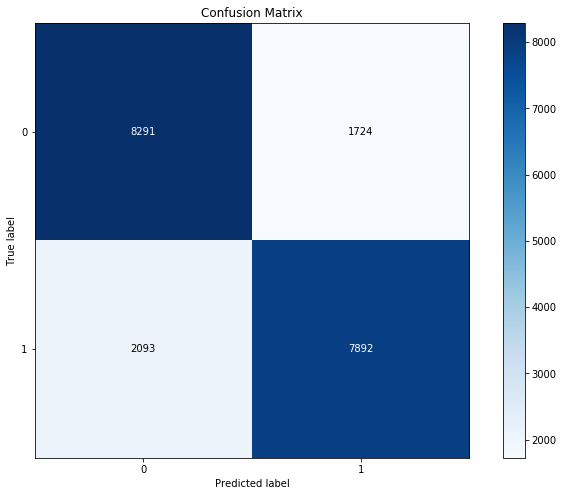

In [20]:
#How accuate our model is?
cm=confusion_matrix(test_sentiment,rfc_predict)
#plot our confusion matrix
skplt.metrics.plot_confusion_matrix(test_sentiment,rfc_predict,normalize=False,figsize=(12,8))
plt.show()


> 0-Negative class,
> 1-Positive class

From the confusion matrix plot, it is concluded that, the Random Forest classifier with 20 decision trees classified the 81% of the reviews (16183 reviews) correctly & remaining 19% of reviews (3817 reviews) are misclassified.

In [21]:
#print classification report for performance metrics
cr=classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)


Classification report is::
               precision    recall  f1-score   support

           0       0.80      0.83      0.81     10015
           1       0.82      0.79      0.81      9985

   micro avg       0.81      0.81      0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



In [22]:
# ROC curve for Random Forest Classifier
fpr_rf,tpr_rf,threshold_rf=roc_curve(test_sentiment,rfc_predict)
#Area under curve (AUC) score, fpr-False Positive rate, tpr-True Positive rate
auc_rf=auc(fpr_rf,tpr_rf)
print('AUC score for Random Forest classifier::',np.round(auc_rf,3))

AUC score for Random Forest classifier:: 0.809


** Let's build our deep learning model**


> Recurrent neural network (RNN) with LSTM (Long Short Term Memory) model

In [23]:
#Train dataset
X_train=train_cv
X_train=[str(x[0]) for x in X_train]
y_train=train_sentiment
# Test dataset
X_test=test_cv
X_test=[str(x[0]) for x in X_test]
y_test=test_sentiment


In [24]:
# Tokenize the train & test dataset
Max_Review_length=500
tokenizer=Tokenizer(num_words=Max_Review_length,lower=False)
tokenizer.fit_on_texts(X_train)
#tokenizig train data
X_train_token=tokenizer.texts_to_sequences(X_train)
#tokenizing test data
X_test_token=tokenizer.texts_to_sequences(X_test)

#Truncate or pad the dataset for a length of 500 words for each review
X_train=pad_sequences(X_train_token,maxlen=Max_Review_length)
X_test=pad_sequences(X_test_token,maxlen=Max_Review_length)

In [25]:
print('Shape of X_train datset after padding:',X_train.shape)
print('Shape of X_test dataset after padding:',X_test.shape)

Shape of X_train datset after padding: (30000, 500)
Shape of X_test dataset after padding: (20000, 500)


In [26]:
%%time
# Most poplar words found in the dataset
vocabulary_size=5000 
embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size,embedding_size,input_length=Max_Review_length))
model.add(LSTM(30))
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 331,431
Trainable params: 331,431
Non-trainable params: 0
_________________________________________________________________
CPU times: user 204 ms, sys: 8 ms, total: 212 ms
Wall time: 211 ms


In [27]:
#Complile our model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
%%time
#Train our model
batch_size=128
num_epochs=6
X_valid,y_valid=X_train[:batch_size],train_sentiment[:batch_size]
X_train1,y_train1=X_train[batch_size:],train_sentiment[batch_size:]
# Fit the model
model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),validation_split=0.2,
          batch_size=batch_size,epochs=num_epochs, verbose=1,shuffle=True)


Instructions for updating:
Use tf.cast instead.
Train on 29872 samples, validate on 128 samples
Epoch 1/6
29872/29872 [==============================] - 154s 5ms/step - loss: 0.6018 - acc: 0.6633 - val_loss: 0.4641 - val_acc: 0.7578
Epoch 2/6
29872/29872 [==============================] - 155s 5ms/step - loss: 0.4859 - acc: 0.7692 - val_loss: 0.4298 - val_acc: 0.7969
Epoch 3/6
29872/29872 [==============================] - 153s 5ms/step - loss: 0.4623 - acc: 0.7847 - val_loss: 0.4166 - val_acc: 0.8047
Epoch 4/6
29872/29872 [==============================] - 156s 5ms/step - loss: 0.4557 - acc: 0.7828 - val_loss: 0.4646 - val_acc: 0.7969
Epoch 5/6
29872/29872 [==============================] - 153s 5ms/step - loss: 0.4566 - acc: 0.7852 - val_loss: 0.4092 - val_acc: 0.8125
Epoch 6/6
29872/29872 [==============================] - 156s 5ms/step - loss: 0.4511 - acc: 0.7860 - val_loss: 0.4314 - val_acc: 0.8125
CPU times: user 20min 37s, sys: 1min 41s, total: 22min 19s
Wall time: 15min 28s


In [29]:
%%time
# Predictions
y_predict_rnn=model.predict(X_test)
#Changing the shape of y_predict to 1-Dimensional
y_predict_rnn1=y_predict_rnn.ravel()
y_predict_rnn1=(y_predict_rnn1>0.5)
y_predict_rnn1[0:10]

CPU times: user 3min 24s, sys: 25.5 s, total: 3min 50s
Wall time: 2min 23s


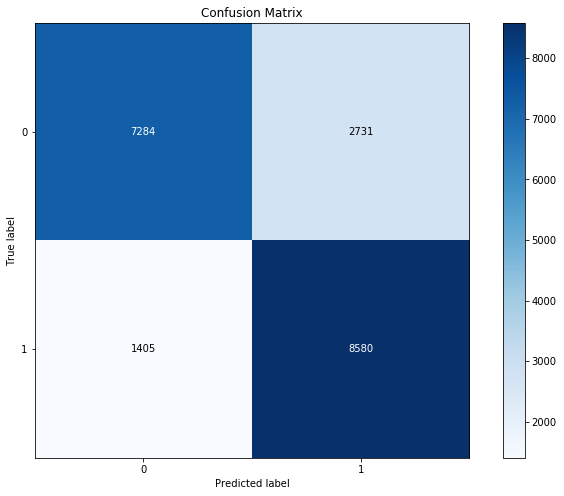

In [30]:
#Confusion matrix for RNN with LSTM
cm_rnn=confusion_matrix(y_test,y_predict_rnn1)
#plot our confusion matrix
skplt.metrics.plot_confusion_matrix(y_test,y_predict_rnn1,normalize=False,figsize=(12,8))
plt.show()



> 0-Negative class,
> 1-Positive class

The confusion matrix plot states that the RNN with LSTM model classified 79% of reviews (15866 reviews) correctly & remaining 21% of reviews (4134 reviews) are misclassified.

In [31]:
#Classification report for performance metrics
cr_rnn=classification_report(y_test,y_predict_rnn1)
print('The Classification report is::\n',cr_rnn)


The Classification report is::
               precision    recall  f1-score   support

           0       0.84      0.73      0.78     10015
           1       0.76      0.86      0.81      9985

   micro avg       0.79      0.79      0.79     20000
   macro avg       0.80      0.79      0.79     20000
weighted avg       0.80      0.79      0.79     20000



In [32]:
#ROC curve for RNN with LSTM
fpr_rnn,tpr_rnn,thresold_rnn=roc_curve(y_test,y_predict_rnn)
#AUC score for RNN
auc_rnn=auc(fpr_rnn,tpr_rnn)
print('AUC score for RNN with LSTM ::',np.round(auc_rnn,3))

AUC score for RNN with LSTM :: 0.878


> **Receiver Operating Characterstic (ROC) Curve for Model Evaluation**

> Now, let's plot the ROC for both Random Forest Classifier &  RNN with LSTM

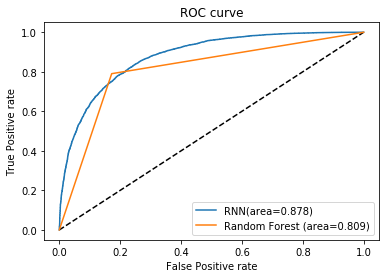

CPU times: user 240 ms, sys: 160 ms, total: 400 ms
Wall time: 213 ms


In [33]:
%%time
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rnn,tpr_rnn,label='RNN(area={:.3f})'.format(auc_rnn))
plt.plot(fpr_rf,tpr_rf,label='Random Forest (area={:.3f})'.format(auc_rf))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [34]:
#Model Evaluation on unseen dataset
Model_evaluation=pd.DataFrame({'Model':['Random Forest Classifier','RNN with LSTM'],
                              'f1_score':[0.81,0.79],
                              'roc_auc_score':[0.809,0.879]})
Model_evaluation

,Model,f1_score,roc_auc_score
0,Random Forest Classifier,0.81,0.809
1,RNN with LSTM,0.79,0.879


The f1_score for Random forest classier is higher than for RNN with LSTM model & the roc_auc score for Random forest classifier is lower than for RNN with LSTM model. From the above scores, it is good to consider Random forest classifier than RNN with LSTM because it is comparatively less computationally expensive & works well on small & large amount of datasets.